<a href="https://colab.research.google.com/github/jumafernandez/imbalanced_data/blob/main/notebooks/oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de estrategias de Oversampling

__Autor:__ Juan Manuel Fernandez

__Objetivo:__ En esta notebook se prueban algunas de las estrategias más conocidas de over-sampling para el remuestreo de datasets a partir de la generación sintética de ejemplos en las clases minoritarias.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [42]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga del dataset.

In [43]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [44]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

Y las utilizadas para la representación de documentos.

In [45]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import representacion_documentos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [46]:
import warnings
from os import path
import pandas as pd
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

etiquetas = get_clases()

# Chequeo sobre si los archivos están en el working directory
if not(path.exists(TRAIN_FILE)):
  # Genero el enlace completo
  URL_file_train = DS_DIR + TRAIN_FILE
  URL_file_test = DS_DIR + TEST_FILE
  # Descargo los archivos
  import wget
  wget.download(URL_file_train)
  wget.download(URL_file_test)
  
# Leemos el archivo en un dataframe
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
consultas_train = list(preprocesar_correos(df_train['consulta']))
consultas_test = list(preprocesar_correos(df_test['consulta']))

print(f"\nEl conjunto de entrenamiento tiene la dimensión: {len(consultas_train)}.")
print(f"El conjunto de testeo tiene la dimensión: {len(consultas_test)}.")

y_train = list(df_train['clase'])
y_test = list(df_test['clase'])


El conjunto de entrenamiento tiene la dimensión: 800.
El conjunto de testeo tiene la dimensión: 200.


### Estrategia de representación de la consulta

A continuación se representa la consulta a partir de features.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,4), token_pattern = '[\w\/\%]+')

X_train = vectorizer.fit_transform(consultas_train)
X_test = vectorizer.transform(consultas_test)     

# Esta función va dentro de un iterador entre las 5 estrategias   
estrategia = '3-4-NGRAM-CHARS' 
print('Estrategia de representación: {}' . format(estrategia))



Estrategia de representación: 3-4-NGRAM-CHARS


## Estrategias de Over-sampling

Se trabaja con las estrategias de over-sampling.

### Sobremuestreo aleatorio ingenuo (RandomOverSampler)

Una forma de combatir este problema es generar nuevas muestras en las clases que están subrepresentadas. La estrategia más ingenua es generar nuevas muestras mediante muestreo aleatorio con reemplazo de las muestras disponibles actualmente.

In [48]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

In [49]:
import numpy as np

unique, counts = np.unique(y_resampled_ros, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '193'],
       ['Cambio de Carrera', '193'],
       ['Cambio de Comisión', '193'],
       ['Consulta por Equivalencias', '193'],
       ['Consulta por Legajo', '193'],
       ['Consulta sobre Título Universitario', '193'],
       ['Cursadas', '193'],
       ['Datos Personales', '193'],
       ['Exámenes', '193'],
       ['Ingreso a la Universidad', '193'],
       ['Pedido de Certificados', '193'],
       ['Problemas con la Clave', '193'],
       ['Reincorporación', '193'],
       ['Requisitos de Ingreso', '193'],
       ['Simultaneidad de Carreras', '193'],
       ['Situación Académica', '193']], dtype='<U35')

### SMOTE

Hay una serie de métodos disponibles para sobremuestrear un conjunto de datos utilizado en un problema de clasificación típico, siendo el más utilizado SMOTE.

In [50]:
from imblearn.over_sampling import SMOTE

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train, y_train)

In [51]:
import numpy as np

unique, counts = np.unique(y_resampled_smote, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '193'],
       ['Cambio de Carrera', '193'],
       ['Cambio de Comisión', '193'],
       ['Consulta por Equivalencias', '193'],
       ['Consulta por Legajo', '193'],
       ['Consulta sobre Título Universitario', '193'],
       ['Cursadas', '193'],
       ['Datos Personales', '193'],
       ['Exámenes', '193'],
       ['Ingreso a la Universidad', '193'],
       ['Pedido de Certificados', '193'],
       ['Problemas con la Clave', '193'],
       ['Reincorporación', '193'],
       ['Requisitos de Ingreso', '193'],
       ['Simultaneidad de Carreras', '193'],
       ['Situación Académica', '193']], dtype='<U35')

### ADASYN

Hay una serie de métodos disponibles para sobremuestrear un conjunto de datos utilizado en un problema de clasificación típico, siendo el más utilizado SMOTE.

In [52]:
from imblearn.over_sampling import ADASYN

X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)

In [53]:
import numpy as np

unique, counts = np.unique(y_resampled_adasyn, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '193'],
       ['Cambio de Carrera', '194'],
       ['Cambio de Comisión', '193'],
       ['Consulta por Equivalencias', '194'],
       ['Consulta por Legajo', '193'],
       ['Consulta sobre Título Universitario', '193'],
       ['Cursadas', '182'],
       ['Datos Personales', '192'],
       ['Exámenes', '193'],
       ['Ingreso a la Universidad', '177'],
       ['Pedido de Certificados', '194'],
       ['Problemas con la Clave', '184'],
       ['Reincorporación', '198'],
       ['Requisitos de Ingreso', '197'],
       ['Simultaneidad de Carreras', '191'],
       ['Situación Académica', '188']], dtype='<U35')

### BorderlineSMOTE

In [54]:
from imblearn.over_sampling import BorderlineSMOTE

X_resampled_border, y_resampled_border = BorderlineSMOTE().fit_resample(X_train, y_train)

In [55]:
import numpy as np

unique, counts = np.unique(y_resampled_border, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', '193'],
       ['Cambio de Carrera', '193'],
       ['Cambio de Comisión', '193'],
       ['Consulta por Equivalencias', '193'],
       ['Consulta por Legajo', '193'],
       ['Consulta sobre Título Universitario', '193'],
       ['Cursadas', '193'],
       ['Datos Personales', '6'],
       ['Exámenes', '193'],
       ['Ingreso a la Universidad', '193'],
       ['Pedido de Certificados', '193'],
       ['Problemas con la Clave', '193'],
       ['Reincorporación', '193'],
       ['Requisitos de Ingreso', '193'],
       ['Simultaneidad de Carreras', '193'],
       ['Situación Académica', '193']], dtype='<U35')

## Generación de Modelos

Se generan modelos en función de los datos originales como así también a partir de las estrategias de oversampling.

Se define el espacio de búsqueda para el ajuste de hiperparámetros de todos los modelos:

In [56]:
BUSCA_MEJOR_MODELO = True

if BUSCA_MEJOR_MODELO:
  # Defino los parámetros para GridSearchCV
  params_svm = {'C': [0.01, 0.1, 1], 
                'gamma': [0.1, 0.01],
                'class_weight': [None, 'balanced'],
                'kernel': ['rbf', 'linear', 'sigmoid']
                }

Se importan las librerías a utilizar:

In [57]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Vemos un reporte de clasificación de varias métricas
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score


### Modelo con dataset original, sin remuestreo

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [58]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test) 

# Modelo a "mano"
#clf = SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='linear')
#clf.fit(X_resampled, y_resampled)
#clf.fit(X_train, y_train)
# Genero las clases para los casos de prueba, según el modelo
#predictions = clf.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [59]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.47      0.89      0.90      0.62      0.89      0.80        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el oversampling de RamdomOverSampler

In [60]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_ros, y_resampled_ros)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [61]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.50      0.89      0.91      0.64      0.90      0.81        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el oversampling de SMOTE

In [62]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_smote, y_resampled_smote)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [63]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.49      0.89      0.90      0.63      0.90      0.81        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el oversampling de ADASYN

In [64]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_adasyn, y_resampled_adasyn)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [65]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.49      0.89      0.90      0.63      0.90      0.81        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

### Modelo con el oversampling de BorderSMOTE

In [66]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_border, y_resampled_border)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [67]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.00      0.00      0.99      0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      1.00      0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.33      1.00      0.50      0.58      0.31         3
                Consulta por Legajo       0.75      1.00      0.99      0.86      1.00      1.00         3
Consulta sobre Título Universitario       0.50      0.33      0.99      0.40      0.58      0.31         3
                           Cursadas       0.47      0.84      0.90      0.60      0.87      0.75        19
                   Datos Personales       0.00      0.00      1.00      0.00      0.00      0.00         2
                           Exámenes 

## Matriz de confusión

Se genera una matriz de confusión de uno de los modelos.

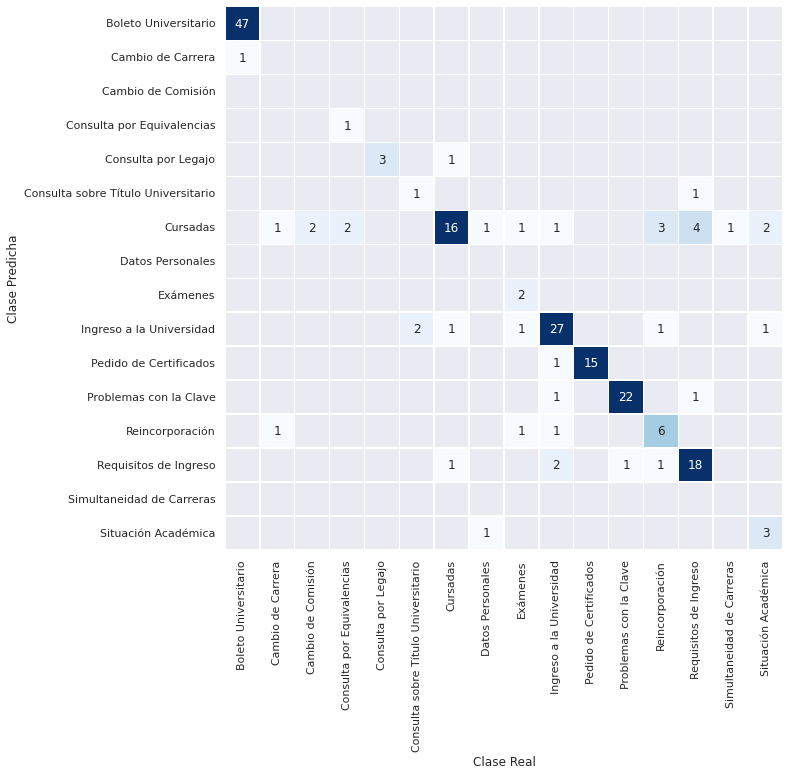

In [68]:
def matriz_confusion(y_real, y_predictions):
  """
  Grafica una matriz de confusión con seaborn en función de la clase observada
  y la clase predicha.
  """

  import numpy as np
  from sklearn import metrics
  import seaborn as sns
  import matplotlib.pyplot as plt
  
  matriz_confusion = metrics.confusion_matrix(y_real, y_predictions).T
  etiquetas = np.unique(y_real)

  sns.set()
  my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
  for i in range(matriz_confusion.shape[0]):
      for j in range(matriz_confusion.shape[0]):
          my_mask[i][j] = matriz_confusion[i][j] == 0 
    
  fig_dims = (10, 10)
  plt.subplots(figsize=fig_dims)

  ax = sns.heatmap(matriz_confusion,
                  xticklabels=etiquetas,
                  annot=True, 
                  fmt="d", 
                  linewidths=.5, 
                  cmap="Blues", 
                  cbar=False, 
                  mask=my_mask, 
                  vmax=15)

  plt.gcf().set_size_inches(10, 10)
  plt.xticks(rotation=90, ha="center")
  plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

  plt.xlabel('Clase Real')
  plt.ylabel('Clase Predicha');

  plt.show()

matriz_confusion(y_test, predictions)

# Referencias
- imbalanced-learn documentation https://imbalanced-learn.org/
- sklearn.model_selection.GridSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- ML Pipelines using scikit-learn and GridSearchCV https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05